In [54]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, chi2

In [55]:
df  = pd.read_csv('nursery.csv')

In [56]:
df.head()

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [57]:
# Check for missing values 
df.isnull().sum()

parents             0
has_nurs            0
form                0
children            0
housing             0
finance             0
social              0
health              0
final evaluation    0
dtype: int64

In [58]:
# let's check the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   parents           12960 non-null  object
 1   has_nurs          12960 non-null  object
 2   form              12960 non-null  object
 3   children          12960 non-null  object
 4   housing           12960 non-null  object
 5   finance           12960 non-null  object
 6   social            12960 non-null  object
 7   health            12960 non-null  object
 8   final evaluation  12960 non-null  object
dtypes: object(9)
memory usage: 911.4+ KB


In [59]:
# let's check the duplicate values
df.duplicated().sum()

0

In [60]:
# It seems health and final evaluation are the same, let's check if they are the same
df['health'].equals(df['final evaluation'])

False

In [61]:
df.shape   

(12960, 9)

In [62]:
# let's see each unique value in each column
for col in df.columns:
    print(col, df[col].unique())

parents ['usual' 'pretentious' 'great_pret']
has_nurs ['proper' 'less_proper' 'improper' 'critical' 'very_crit']
form ['complete' 'completed' 'incomplete' 'foster']
children ['1' '2' '3' 'more']
housing ['convenient' 'less_conv' 'critical']
finance ['convenient' 'inconv']
social ['nonprob' 'slightly_prob' 'problematic']
health ['recommended' 'priority' 'not_recom']
final evaluation ['recommend' 'priority' 'not_recom' 'very_recom' 'spec_prior']


In [63]:
# let's see any relationship between parent and final evaluation
parents_final_evaluation = df.groupby('parents')['final evaluation'].value_counts()
parents_final_evaluation = parents_final_evaluation.sort_values(ascending=False).reset_index(name='count')
parents_final_evaluation

,parents,final evaluation,count
0,great_pret,spec_prior,2022
1,usual,priority,1924
2,pretentious,priority,1484
3,great_pret,not_recom,1440
4,pretentious,not_recom,1440
5,usual,not_recom,1440
6,pretentious,spec_prior,1264
7,great_pret,priority,858
8,usual,spec_prior,758
9,usual,very_recom,196


In [64]:
# According to the data description and grouping the data:
# Special Priority: Mostly given to parents with great pretension or pretentious occupations.
# Priority: Commonly given to usual parents.
# Not Recommended: Evenly distributed across parents' categories.
# Very recommend and recommend are rare decisions.

Text(0, 0.5, 'Count')

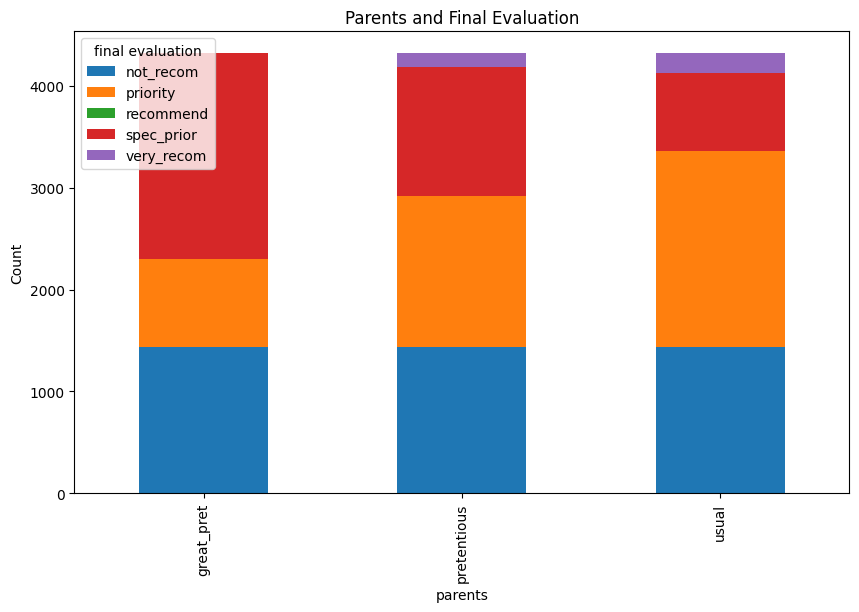

In [65]:
ct = pd.crosstab(df['parents'], df['final evaluation'])
ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Parents and Final Evaluation')
plt.ylabel('Count')

In [66]:
# Family structure(form) might have strong relationship with final evaluation
form_final_evaluation = df.groupby('form')['final evaluation'].value_counts()
form_final_evaluation = form_final_evaluation.sort_values(ascending=False).reset_index(name='count')
form_final_evaluation


,form,final evaluation,count
0,complete,priority,1152
1,foster,spec_prior,1136
2,completed,priority,1092
3,incomplete,not_recom,1080
4,completed,not_recom,1080
5,complete,not_recom,1080
6,foster,not_recom,1080
7,incomplete,spec_prior,1052
8,incomplete,priority,1038
9,foster,priority,984


In [67]:
# Complete families get higher evaluations (priority and special priority)

Text(0.5, 1.0, 'Family Structure vs Final Evaluation')

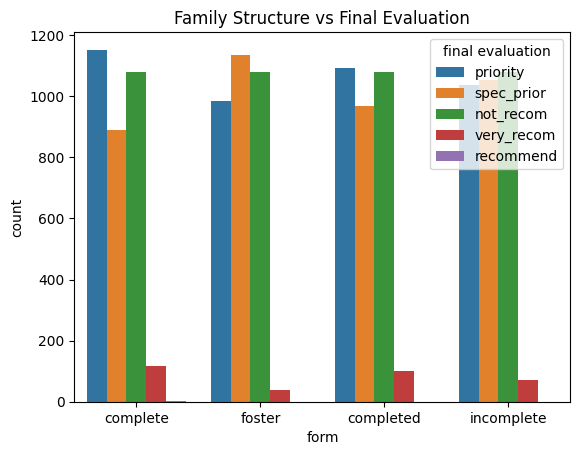

In [68]:
sns.barplot(data=form_final_evaluation, x='form', y='count', hue='final evaluation')
plt.title('Family Structure vs Final Evaluation')

In [69]:
# let's check the target variable(final evaluation)
df['final evaluation'].value_counts()

final evaluation
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: count, dtype: int64

In [70]:
# recommend and very recommend are rare decisions,  I dont consider them.
df = df[df['final evaluation'] != 'recommend']
df = df[df['final evaluation'] != 'very_recom']

In [71]:
df['final evaluation'].value_counts()

final evaluation
not_recom     4320
priority      4266
spec_prior    4044
Name: count, dtype: int64

In [72]:
label_encoder = LabelEncoder()
df['final evaluation'] = label_encoder.fit_transform(df['final evaluation'])

In [73]:
# let's check the parent column
df['parents'].value_counts()

parents
great_pret     4320
pretentious    4188
usual          4122
Name: count, dtype: int64

In [74]:
# Using dummy encoding for parents column
parent_one_hot = pd.get_dummies(df['parents'], drop_first=True).astype(int)
df = pd.concat([df, parent_one_hot], axis=1)
df.drop('parents', axis=1, inplace=True)

In [75]:
# let's check the children column
df['children'].value_counts()

children
3       3200
more    3200
2       3140
1       3090
Name: count, dtype: int64

In [76]:
# Using dummy encoding for children column
children_one_hot = pd.get_dummies(df['children'], drop_first=True).astype(int)
df = pd.concat([df, children_one_hot], axis=1)
df.drop('children', axis=1, inplace=True)

In [77]:
# let's check the housing column
df['housing'].value_counts()

housing
critical      4300
less_conv     4220
convenient    4110
Name: count, dtype: int64

In [78]:
# Using dummy encoding for housing column
housing_one_hot = pd.get_dummies(df['housing'], drop_first= True).astype(int)
df = pd.concat([df, housing_one_hot], axis=1)
df = df.drop(columns=['housing'])

In [79]:
# let's check the has_nurs column
df['has_nurs'].value_counts()

has_nurs
critical       2592
very_crit      2592
improper       2526
proper         2460
less_proper    2460
Name: count, dtype: int64

In [80]:
# Using dummy encoding for has_nurs column
has_nurs_one_hot = pd.get_dummies(df['has_nurs'], drop_first= True).astype(int)
df = pd.concat([df, has_nurs_one_hot], axis=1)
df.drop('has_nurs', axis=1, inplace=True)

In [81]:
# lt's check the form column
df['form'].value_counts()

form
foster        3200
incomplete    3170
completed     3140
complete      3120
Name: count, dtype: int64

In [82]:
# using dummy encoding for form column  
form_one_hot = pd.get_dummies(df['form'], drop_first= True).astype(int)
df = pd.concat([df, form_one_hot], axis=1)
df = df.drop(columns=['form'])

In [83]:
# let's check the finance column
df['finance'].value_counts()

finance
inconv        6370
convenient    6260
Name: count, dtype: int64

In [84]:
# using label encoding for finance column
df['finance'] = label_encoder.fit_transform(df['finance'])

In [85]:
# let's check the social column
df['social'].value_counts()

social
problematic      4320
nonprob          4155
slightly_prob    4155
Name: count, dtype: int64

In [86]:
# Using dummy encoding for social column
social_one_hot = pd.get_dummies(df['social'], drop_first= True).astype(int)
df = pd.concat([df, social_one_hot], axis=1)
df = df.drop(columns=['social'])

In [87]:
# let's check the health column
df['health'].value_counts()

health
priority       4320
not_recom      4320
recommended    3990
Name: count, dtype: int64

In [88]:
# Using dummy encoding for health column
health_one_hot = pd.get_dummies(df['health'], drop_first= True).astype(int)
df = pd.concat([df, health_one_hot], axis=1)
df = df.drop(columns=['health'])

In [89]:
# The dataset got 20 columns after encoding the categorical columns,and that is a lot of columns.

In [90]:
# Renaming 2 and 3 columns 
df = df.rename(columns={'2': '2_children', '3': '3_children', 'more': 'more_children'})

In [91]:
df.head()

,finance,final evaluation,pretentious,usual,2_children,3_children,more_children,critical,less_conv,improper,less_proper,proper,very_crit,completed,foster,incomplete,problematic,slightly_prob,priority,recommended
1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [92]:
df.shape

(12630, 20)

In [93]:
X = df.drop(columns=['final evaluation'])
y = df['final evaluation']

In [94]:
# Calculate the VIF for each feature
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,Features,VIF
0,finance,1.92
1,pretentious,1.83
2,usual,1.82
3,2_children,1.81
4,3_children,1.83
5,more_children,1.83
6,critical,1.90
7,less_conv,1.87
8,improper,1.74
9,less_proper,1.72


In [95]:
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)  

chi_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_features.fit(X_cat, y.astype(int))

# use decimal format in table
pd.options.display.float_format = '{:.2f}'.format

df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns, df_features], axis=1)
f_scores.columns = ['Features', 'Score']
f_scores.sort_values(by='Score', ascending=False)

,Features,Score
17,priority,2432.06
18,recommended,2275.92
11,very_crit,1076.89
10,proper,681.74
9,less_proper,681.74
2,usual,442.87
15,problematic,84.25
6,critical,67.11
16,slightly_prob,21.90
5,more_children,20.98


In [96]:
# let's drop the columns with lower than 18 score
df = df.drop(['pretentious', 'improper', 'incomplete', '2_children', 'completed', 'less_conv'], axis=1)

In [97]:
# I need rename the columns to match the original column names
# I map of old column names to new names
rename_dict = {
    'finance': 'Financial Standing',
    'usual': 'Usual Occupation',
    '3_children': 'Three Children',
    'more_children': 'More than Three Children',
    'critical': 'Critical Housing',
    'less_proper': 'Less Proper Nursery',
    'proper': 'Proper Nursery',
    'very_crit': 'Very Critical Nursery',
    'foster': 'Foster Family',
    'problematic': 'Problematic Social Conditions',
    'slightly_prob': 'Slightly Problematic Social Conditions',
    'priority': 'Priority Health Recommendation',
    'recommended': 'Recommended Health Status'
}

In [98]:
df = df.rename(columns=rename_dict)

In [99]:
df.head()

,Financial Standing,final evaluation,Usual Occupation,Three Children,More than Three Children,Critical Housing,Less Proper Nursery,Proper Nursery,Very Critical Nursery,Foster Family,Problematic Social Conditions,Slightly Problematic Social Conditions,Priority Health Recommendation,Recommended Health Status
1,0,1,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,1,0,0,0,0,0,0
4,0,1,1,0,0,0,0,1,0,0,0,1,1,0
5,0,0,1,0,0,0,0,1,0,0,0,1,0,0
6,0,1,1,0,0,0,0,1,0,0,1,0,0,1


In [106]:
df.shape

(12630, 14)

In [100]:
x_train , x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [101]:
#knn_model = KNeighborsClassifier(n_neighbors=5) 

#knn_model.fit(x_train, y_train)

In [102]:
# I am gonna do fine tuning with GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid, cv=5, scoring='balanced_accuracy')
grid.fit(x_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
0.9520593917393653


In [103]:
forecast = grid.predict(x_test)

In [104]:
accuracy = accuracy_score(y_test, forecast)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("\nClassification Report:")
print(classification_report(y_test, forecast))


Accuracy: 95.72%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1307
           1       0.92      0.95      0.94      1281
           2       0.95      0.91      0.93      1201

    accuracy                           0.96      3789
   macro avg       0.96      0.96      0.96      3789
weighted avg       0.96      0.96      0.96      3789



Text(95.72222222222221, 0.5, 'Actual')

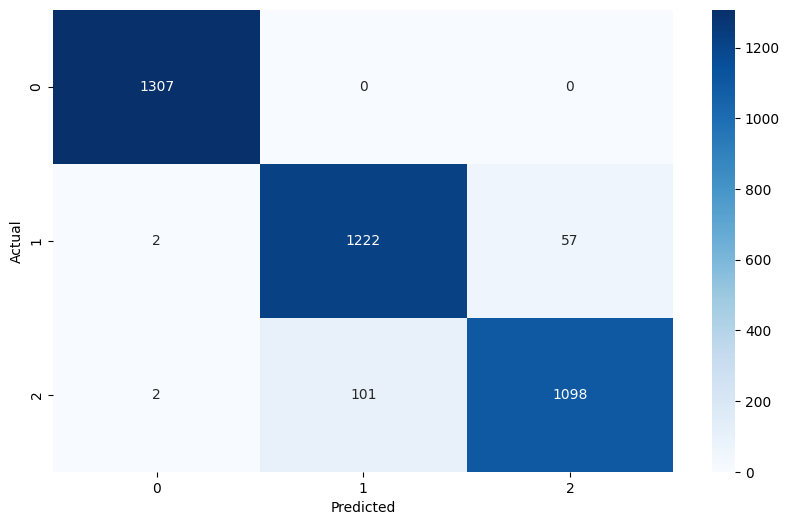

In [105]:
confusion_matrix(y_test, forecast)
# Visualizing the confusion matrix using heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, forecast), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## <span style="color: #20C997;">Personal Analysis</span>
The dataset had some columns with categories that had many options, and some with only two option For the columns with lots of options, I used one-hot encoding, I also did label encoding for the target column.<br>
For my first KNN model, I picked a default KNeighborsClassifier(n_neighbors=5). It gave me around 93.82% accuracy. The classification report showed that precision, recall, and f1‐scores were high.<br>
But class 2 had a lower recall compared to the others. Next, I used GridSearchCV to check different values. Accuracy is 95.72 % and  precision/recall/ f1 are above 90%.<br>
I also looked at the confusion matrix. It showed fewer misclassifications compared to before tuning. 